In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('../../'); from config import *
configure_pylab()

plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

Available files:
	r2288_180515b_tet2_cell2_GC.mat
	r2289_250515b_tet2_cell2_GC.mat
	r2298_290615c_tet6_cell6_GC.mat
	r2375_070416a_tet1_cell1_GC.mat
	r2375_140416b_tet1_cell1_GC.mat
	r2375_210416a_tet3_cell3_GC.mat
	r2383_160516b_tet4_cell4_GC.mat
	r2405_011216a_cell2955.mat
	r2405_051216b_cell1816.mat
	r2405_121216b_cell1880.mat
	r2405_121216b_cell1912.mat
	r2405_191216c_cell1640.mat
	r2405_191216c_cell1662.mat
	r2405_191216c_cell1962.mat
	r2405_191216c_cell1990.mat
Fitted models in fitdir = /home/mer49/Desktop/lgcpspatial/python/notebooks/hyperparameter_fits/


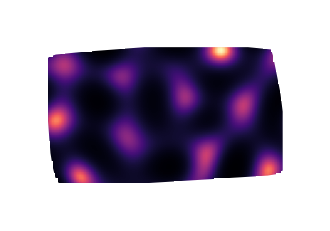

In [3]:
L     = 128
#fn    = 'r2289_250515b_tet2_cell2_GC.mat'
fn    = 'r2405_051216b_cell1816.mat'
data  = Dataset.from_file(datadir+fn).prepare(L,)
arena = data.arena

result = lgcp2d(
    kernelft(
        data.shape,data.P,data.V,
        angle=data.angle,style='grid'),
    data.N,data.K,data.prior_mean)[0]
arena.imshow(result.info.r)

In [5]:
P,V,θ = pickle.load(open(fitdir+fn[:-3]+'hyperparameters.p','rb'))
print('(P,V,θ)=',(P,V,θ))

(P,V,θ)= (22.428381, 0.26807135, 0.2617993877991494)


In [6]:
rp = 2   # Range (ratio) to search for optimal period
rv = 10  # Range (ratio) to search for optimal kernel height
rw = 100 # Range (ratio) to search for optimal white noise
Np = 101 # Period grid resolution
Nv = 101 # Kernel height grid resolution
Nθ = 60  # Angles to test

# Prepare hyperparameter grid
Ps = float32(exp(linspace(log(P/rp),log(P*rp),Np)))
Vs = float32(exp(linspace(log(V/rv),log(V*rv),Nv))[::-1])
θs = linspace(0,pi/3,Nθ+1)[:Nθ]

In [7]:
to_bps = 1/sum(data.N)*data.position_sample_rate/log(2)
baseline = sum(data.N*(data.Y*slog(data.Y)-data.Y))*to_bps
limit_cores(1)
kw = dict(P=P,V=V,style='grid',angle=θ)
kept = full(data.shape,False)
for Pi in Ps: kept |= kernelft(data.shape,**(kw|dict(P=Pi)))>0
for Vi in Vs: kept |= kernelft(data.shape,**(kw|dict(V=Vi)))>0
for θi in θs: kept |= kernelft(data.shape,**(kw|dict(angle=θi)))>0
NKμ = (data.N,data.K,data.prior_mean)
loss = lambda kw:lgcp2d(kernelft(data.shape,**kw),*NKμ)[0].ll
llp = float32(parmap(lambda Pi:loss(kw|dict(P=Pi    ,kept=kept)),Ps))*to_bps-baseline
llv = float32(parmap(lambda Vi:loss(kw|dict(V=Vi    ,kept=kept)),Vs))*to_bps-baseline
llh = float32(parmap(lambda θi:loss(kw|dict(angle=θi,kept=kept)),θs))*to_bps-baseline

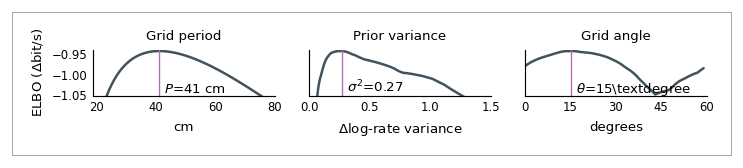

In [8]:
a,b = percentile(llh,[4,100])
b += 0.001
b = ceil(b*100)/100
a = floor(a*100)/100
yl = (a,b)

figure(0,(6,1.2),120)
subplot(131)
pmax = Ps[argmax(llp)]
plot(Ps,llv)
ylabel('ELBO ($\\Delta$bit/s)')
simpleaxis()
ylim(*yl)
axvline(pmax,color=MAUVE,lw=.8)
text(pmax+px2x(5),ylim()[0]+px2y(7),'$P$=%0.0f cm'%(100*pmax*arena.meters_per_bin),fontsize=8)
xt = float32([.2,.4,.6,.8])*100
xticks(xt/arena.meters_per_bin/100,['%d'%i for i in xt])
xlim(19/arena.meters_per_bin/100,80/arena.meters_per_bin/100)
title('Grid period')
xlabel('cm')
subplot(132)
vmax = Vs[argmax(llv)]
plot(Vs,llp)
simpleaxis()
xlim(0,1.5)
ylim(*yl)
axvline(vmax,color=MAUVE,lw=.8)
text(vmax+px2x(5),ylim()[0]+px2y(7),'$\\sigma^2$=%0.2f'%vmax,fontsize=8)
noy()
title('Prior variance')
xlabel('$\\Delta$log-rate variance')
subplot(133)
hmax = θs[argmax(llh)]*180/pi
plot(θs*180/pi,llh)
simpleaxis()
ylim(*yl)
axvline(hmax,color=MAUVE,lw=.8)
text(hmax+px2x(5),ylim()[0]+px2y(7),'$\\theta$=%0.0f\\textdegree'%hmax,fontsize=8)
xticks([0,15,30,45,60])
noy()
title('Grid angle')
xlabel('degrees')

tight_layout()
figurebox()
savefig('fig3b_v2.pdf')

In [9]:
kw = dict(P=P,V=V,style='grid',angle=θ)
k  = kernelft(data.shape,**kw)
result = lgcp2d(k,*NKμ)[0]

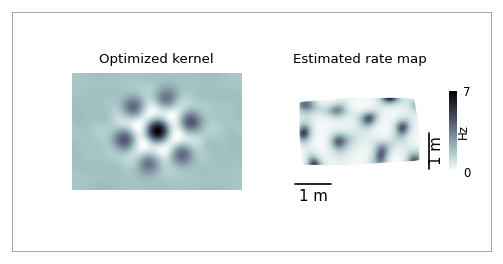

In [10]:
figure(0,(4,2),120)

subplot(121)
imshow(fftshift(ifft2(k).real),extent=arena.extent,cmap='bone_r')
noxyaxes()
title('Optimized kernel')

subplot(122)
im = arena.imshow(result.info.r*data.position_sample_rate,vmin=0,vmax=7,cmap='bone_r')
good_colorbar(*im.get_clim(),cmap='bone_r',title='Hz',width=8,vscale=.7,fontsize=7)
px,py = arena.perim_m.T
yscalebar(nanmax(py)-.25,.5,'1 m',nanmax(px)+px2x(5),side='right')

xscalebar(nanmin(px)+.25,.5,'1 m',nanmax(py)-px2y(15))
title('Estimated rate map')

figurebox()
savefig('fig3c_v2.pdf')